<a href="https://colab.research.google.com/github/kaluznys/uczenie_maszynowe_UW/blob/main/pomoc_obrazki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loaded pretrained model.
Step 0 | Loss: 6.8097 | Mean confidence: 0.0616
Step 50 | Loss: 0.0000 | Mean confidence: 1.0000
Step 100 | Loss: 0.0000 | Mean confidence: 1.0000
Step 150 | Loss: 0.0000 | Mean confidence: 1.0000
Step 200 | Loss: 0.0000 | Mean confidence: 1.0000
Step 250 | Loss: 0.0000 | Mean confidence: 1.0000
Step 300 | Loss: 0.0000 | Mean confidence: 1.0000
Step 350 | Loss: 0.0000 | Mean confidence: 1.0000
Step 400 | Loss: 0.0000 | Mean confidence: 1.0000
Step 450 | Loss: 0.0000 | Mean confidence: 1.0000
Step 500 | Loss: 0.0000 | Mean confidence: 1.0000
Step 550 | Loss: 0.0000 | Mean confidence: 1.0000
Step 600 | Loss: 0.0000 | Mean confidence: 1.0000
Step 650 | Loss: 0.0000 | Mean confidence: 1.0000
Step 700 | Loss: 0.0000 | Mean confidence: 1.0000
Step 750 | Loss: 0.0000 | Mean confidence: 1.0000
Step 800 | Loss: 0.0000 | Mean confidence: 1.0000
Step 850 | Loss: 0.0000 | Mean confidence: 1.0000
Step 900 | Loss: 0.0000 | Mean confidence: 1.0000
Step 950 | Loss: 0.0000 | Me

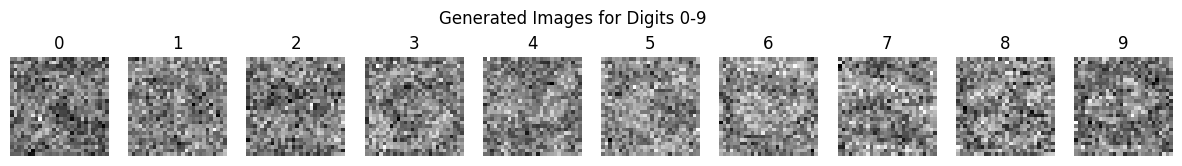

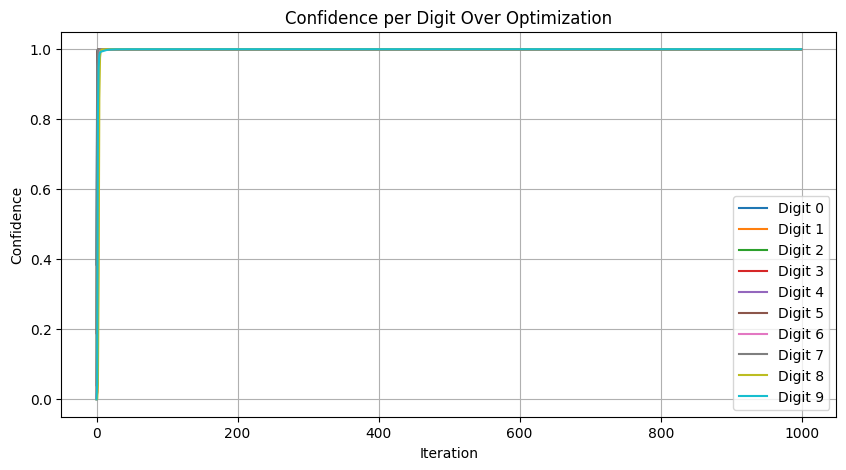

In [12]:
# Required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained MNIST model or define a simple one
class SimpleMNISTModel(nn.Module):
    def __init__(self):
        super(SimpleMNISTModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Load MNIST and train a small model if needed
def load_trained_model():
    model = SimpleMNISTModel().to(device)

    # Load pretrained weights if available, else train quickly
    try:
        model.load_state_dict(torch.load("mnist_model.pth", map_location=device))
        print("Loaded pretrained model.")
    except:
        print("Training model...")
        train_loader = torch.utils.data.DataLoader(
            datasets.MNIST('.', train=True, download=True,
                           transform=transforms.ToTensor()),
            batch_size=64, shuffle=True
        )
        optimizer = torch.optim.Adam(model.parameters())
        loss_fn = nn.CrossEntropyLoss()

        model.train()
        for epoch in range(1):  # Quick 1-epoch train
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = loss_fn(output, target)
                loss.backward()
                optimizer.step()

        torch.save(model.state_dict(), "mnist_model.pth")
        print("Model trained and saved.")

    model.eval()
    return model

# Task 1: Optimize 10 noise images to be classified as digits 0-9
def dream_digits(model, num_steps=1000, lr=0.1):
  target_labels = torch.arange(10, device=device)  # digits 0-9
  dreamed_images = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)

  optimizer = torch.optim.Adam([dreamed_images], lr=lr)
  loss_fn = nn.CrossEntropyLoss()

  history = []
  for step in range(num_steps):
    optimizer.zero_grad()
    output = model(dreamed_images)
    loss = loss_fn(output, target_labels)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
      probs = F.softmax(output, dim=1)
      confidence = probs[torch.arange(10), target_labels].detach().cpu().numpy()
      history.append(confidence)

      if step % 50 == 0 or step == num_steps - 1:
        print(f"Step {step} | Loss: {loss.item():.4f} | Mean confidence: {np.mean(confidence):.4f}")


  with torch.no_grad():
    final_images = dreamed_images.clone().detach().cpu().squeeze()

  return final_images, np.array(history)

# Plot results
def plot_results(images, confidence_history):
    images = images.cpu().numpy().squeeze()

    fig, axes = plt.subplots(1, 10, figsize=(15, 2))
    for i in range(10):
        axes[i].imshow(images[i], cmap="gray")
        axes[i].axis("off")
        axes[i].set_title(str(i))
    plt.suptitle("Generated Images for Digits 0-9")
    plt.show()

    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.plot(confidence_history[:, i], label=f"Digit {i}")
    plt.xlabel("Iteration")
    plt.ylabel("Confidence")
    plt.title("Confidence per Digit Over Optimization")
    plt.legend()
    plt.grid(True)
    plt.show()

# Main Execution
model = load_trained_model()
model.to(device)
model.eval()
final_images, confidence_history = dream_digits(model)
plot_results(final_images, confidence_history)
